# Illustration of LICQ (for the response)
We use example

$$
\begin{align}
    x_1 + x_2   & \leq y, \\
    x_1 + 2 x_2 & \leq 0, \\
    2 x_1 + x_2 & \leq 0,
\end{align}
$$

to illustrate Linear Independent Constraint Qualification (LICQ).

## Plot the results:

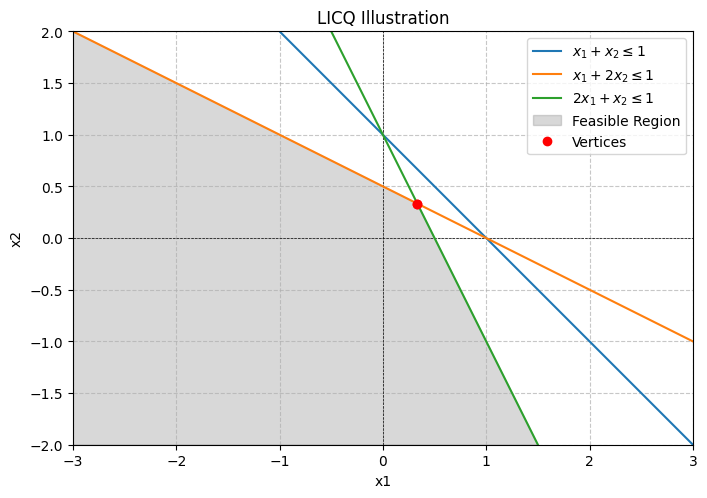

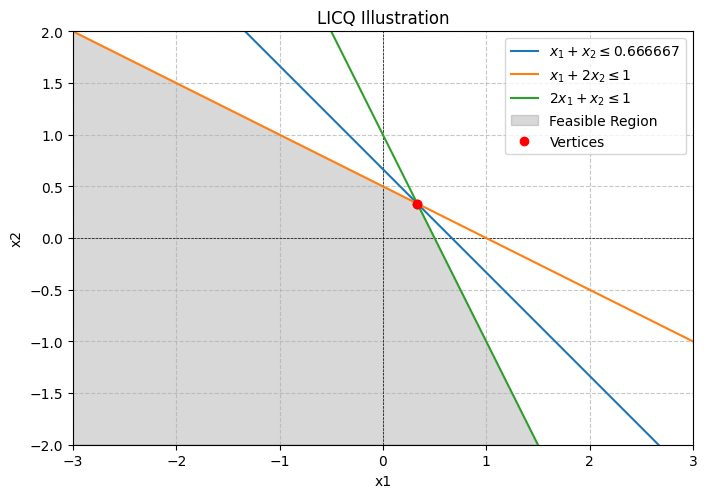

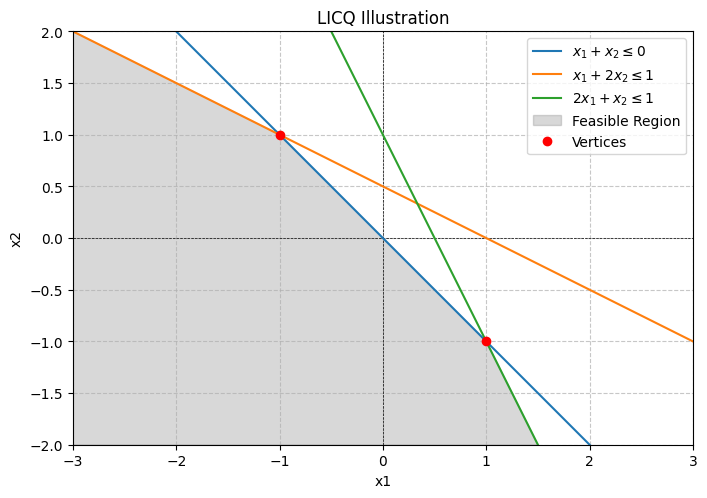

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from numpy.typing import NDArray
from scipy.optimize import linprog, OptimizeResult


def remove_redundancy(
    lhs: NDArray[np.float64], rhs: NDArray[np.float64]
) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
    if lhs.ndim != 2 or lhs.shape[1] != 2:
        raise ValueError("lhs must be a 2D array with shape (n_constraints, 2).")
    if rhs.ndim != 1 or lhs.shape[0] != rhs.shape[0]:
        raise ValueError(
            "rhs must be a 1D array with the same length as the number of constraints in lhs."
        )

    num_constraints = lhs.shape[0]
    keep_indices = np.ones(num_constraints, dtype=bool)

    for i in range(num_constraints):
        temp_lhs = np.delete(lhs, i, axis=0)
        temp_rhs = np.delete(rhs, i)

        res: OptimizeResult = linprog(
            c=-lhs[i],
            A_ub=temp_lhs,
            b_ub=temp_rhs,
            method="highs",
            bounds=(None, None),
            options={"disp": False},
        )

        sussess = res.get("success", False)
        status = res.get("status", 0)
        if sussess and status == 0:
            opt_val = -res.get("fun", 0.0)
        else:
            opt_val = np.inf

        if opt_val < rhs[i]:
            keep_indices[i] = False

    return lhs[keep_indices], rhs[keep_indices]


def calculate_vertices(
    lhs: NDArray[np.float64], rhs: NDArray[np.float64]
) -> NDArray[np.float64]:
    if lhs.ndim != 2 or lhs.shape[1] != 2:
        raise ValueError("lhs must be a 2D array with shape (n_constraints, 2).")
    if rhs.ndim != 1 or lhs.shape[0] != rhs.shape[0]:
        raise ValueError(
            "rhs must be a 1D array with the same length as the number of constraints in lhs."
        )

    lhs_reduced, rhs_reduced = remove_redundancy(lhs, rhs)

    angles = np.arctan2(lhs_reduced[:, 1], lhs_reduced[:, 0])
    sorted_indices = np.argsort(angles)
    sorted_lhs = lhs_reduced[sorted_indices]
    sorted_rhs = rhs_reduced[sorted_indices]

    num_constraints = lhs_reduced.shape[0]
    vertices: list[NDArray[np.float64]] = []
    for i in range(num_constraints):
        j = (i + 1) % num_constraints
        temp_lhs = np.vstack((sorted_lhs[i], sorted_lhs[j]))
        temp_rhs = np.hstack((sorted_rhs[i], sorted_rhs[j]))
        try:
            vertex = np.linalg.solve(temp_lhs, temp_rhs)
            if np.all(lhs_reduced @ vertex <= rhs_reduced):
                vertices.append(vertex)
        except np.linalg.LinAlgError:
            continue

    return np.vstack(vertices)


def plot_constraints(
    lhs: NDArray[np.float64],
    rhs: NDArray[np.float64],
    x_lim: tuple[float, float] = (-3, 3),
    y_lim: tuple[float, float] = (-2, 2),
    step: float = 0.1,
) -> Figure:
    if lhs.ndim != 2 or lhs.shape[1] != 2:
        raise ValueError("lhs must be a 2D array with shape (n_constraints, 2).")
    if rhs.ndim != 1 or lhs.shape[0] != rhs.shape[0]:
        raise ValueError(
            "rhs must be a 1D array with the same length as the number of constraints in lhs."
        )

    x = np.arange(x_lim[0], x_lim[1] + step, step)

    if lhs.shape[0] > 1:
        vertices = calculate_vertices(lhs, rhs)

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.axhline(0, color="black", linewidth=0.5, linestyle="--")
    ax.axvline(0, color="black", linewidth=0.5, linestyle="--")

    for i in range(A.shape[0]):
        a_i = A[i]
        b_i = b[i]
        terms = []
        # x1 term
        if a_i[0] != 0:
            if a_i[0] == 1:
                terms.append("x_1")
            elif a_i[0] == -1:
                terms.append("-x_1")
            else:
                terms.append(f"{a_i[0]:g}x_1")
        # x2 term
        if a_i[1] != 0:
            sign = "+" if a_i[1] > 0 and terms else ""
            if a_i[1] == 1:
                terms.append(f"{sign}x_2")
            elif a_i[1] == -1:
                terms.append(f"{sign}-x_2")
            else:
                terms.append(f"{sign}{a_i[1]:g}x_2")
        lhs_str = " ".join(terms) if terms else "0"
        constraint_label = f"${lhs_str} \\leq {b_i:g}$"
        ax.plot(x, (b_i - a_i[0] * x) / a_i[1], label=constraint_label)

    lhs_ = np.vstack((lhs, np.eye(2), -np.eye(2)))
    rhs_ = np.hstack((rhs, np.array([x_lim[1], y_lim[1], -x_lim[0], -y_lim[0]])))
    vertices_ = calculate_vertices(lhs_, rhs_)

    ax.fill(
        vertices_[:, 0],
        vertices_[:, 1],
        alpha=0.3,
        color="gray",
        label="Feasible Region",
    )

    if lhs.shape[0] > 1:
        ax.plot(vertices[:, 0], vertices[:, 1], "ro", label="Vertices")

    ax.set_title("LICQ Illustration")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_xlim(*x_lim)
    ax.set_ylim(*y_lim)
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.set_aspect("equal")

    ax.legend()

    return fig


A = np.array([[1.0, 1.0], [1.0, 2.0], [2.0, 1.0]])
b = np.array([1.0, 1.0, 1.0])

fig1 = plot_constraints(A, b)

b[0] = 2 / 3
fig2 = plot_constraints(A, b)

b[0] = 0.0
fig3 = plot_constraints(A, b)

plt.show()

## Save the figures:

In [ ]:
import os

root_dir = os.path.dirname(os.path.dirname(os.getcwd()))
figure_dir = os.path.join(root_dir, "figures", "licq")
os.makedirs(figure_dir, exist_ok=True)

fig1.savefig(os.path.join(figure_dir, "licq_illustration_1.pdf"), bbox_inches="tight")
fig2.savefig(os.path.join(figure_dir, "licq_illustration_2.pdf"), bbox_inches="tight")
fig3.savefig(os.path.join(figure_dir, "licq_illustration_3.pdf"), bbox_inches="tight")